Importing libraries

In [48]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

!conda install -c conda-forge folium=0.5.0 --yes
import folium
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')


Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


Installing Geopy

In [49]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


Convert an address into latitude and longitude values

In [50]:
>>> from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 


Get the entire html of the article as a string.

Transform the text to html.

Extract the information ('Postal Code', 'Borough', 'Neighbourhood') from the table.

Remove empty str (first and last items).

In [51]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text 
html_parsed_result = BeautifulSoup(text_result, 'html.parser') 

neighborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neighborhood_rows = neighborhood_info_table.find_all('tr')


neighborhood_info = []
for row in neighborhood_rows:
    info = row.text.split('\n')[1:-1]
    neighborhood_info.append(info)
    
neighborhood_info[0:10]

[['Postal Code', '', 'Borough', '', 'Neighbourhood'],
 ['M1A', '', 'Not assigned', '', 'Not assigned'],
 ['M2A', '', 'Not assigned', '', 'Not assigned'],
 ['M3A', '', 'North York', '', 'Parkwoods'],
 ['M4A', '', 'North York', '', 'Victoria Village'],
 ['M5A', '', 'Downtown Toronto', '', 'Regent Park, Harbourfront'],
 ['M6A', '', 'North York', '', 'Lawrence Manor, Lawrence Heights'],
 ['M7A',
  '',
  'Downtown Toronto',
  '',
  "Queen's Park, Ontario Provincial Government"],
 ['M8A', '', 'Not assigned', '', 'Not assigned'],
 ['M9A', '', 'Etobicoke', '', 'Islington Avenue, Humber Valley Village']]

In [52]:
for i in range(len(neighborhood_info)):
        if neighborhood_info[i][4]=='':neighborhood_info[i][4]='Not assigned'
neighborhood_info[0:10]

[['Postal Code', '', 'Borough', '', 'Neighbourhood'],
 ['M1A', '', 'Not assigned', '', 'Not assigned'],
 ['M2A', '', 'Not assigned', '', 'Not assigned'],
 ['M3A', '', 'North York', '', 'Parkwoods'],
 ['M4A', '', 'North York', '', 'Victoria Village'],
 ['M5A', '', 'Downtown Toronto', '', 'Regent Park, Harbourfront'],
 ['M6A', '', 'North York', '', 'Lawrence Manor, Lawrence Heights'],
 ['M7A',
  '',
  'Downtown Toronto',
  '',
  "Queen's Park, Ontario Provincial Government"],
 ['M8A', '', 'Not assigned', '', 'Not assigned'],
 ['M9A', '', 'Etobicoke', '', 'Islington Avenue, Humber Valley Village']]

In [53]:
neighborhood_info[0][-1] = 'Neighborhood' 
neighborhood_df = pd.DataFrame(neighborhood_info[1:], columns=neighborhood_info[0])

neighborhood_df.head(10)

,Postal Code,,Borough,,Neighborhood
0,M1A,,Not assigned,,Not assigned
1,M2A,,Not assigned,,Not assigned
2,M3A,,North York,,Parkwoods
3,M4A,,North York,,Victoria Village
4,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
5,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
6,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
7,M8A,,Not assigned,,Not assigned
8,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
9,M1B,,Scarborough,,"Malvern, Rouge"


Substract one because "not assigned" doesn't count. 

Substract one because "not assigned" doesn't count.

In [54]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postal Code'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) 
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) 
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Nan Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (180, 5) 

There are:
  180 Postal codes
  10 Boroughs
  99 Neighborhoods
  77 rows with Not assigned Borough
  77 rows with Nan Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



Eliminate the Boroughs that are not assigned

In [55]:

neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postal Code,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [56]:
# Replace the Not assigned values in neighbohood with the Borough value in the cell
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postal Code,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [57]:
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postal Code'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (103, 5) 

There are:
  103 Postal codes
  10 Boroughs
  99 Neighborhoods


In [58]:
group = neighborhood_df.groupby('Postal Code')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postal Code', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [75]:
coordinates_df = pd.read_csv(r'C:\Users\fidel\Downloads\Geospatial_Coordinates.csv')
print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Add the longitude and Latitude to the Pandas data fra

In [76]:
postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postal Code')

postcodes_with_coordinates_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


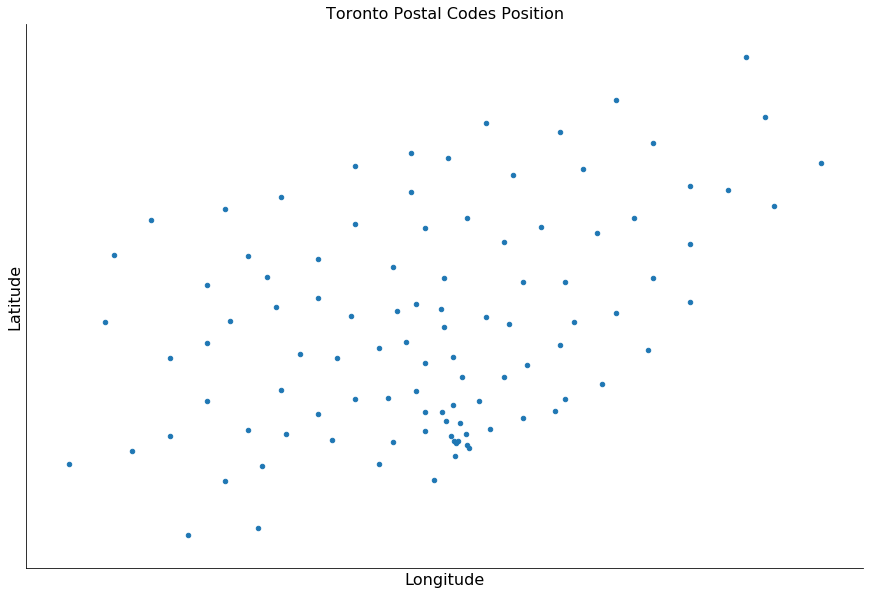

In [77]:
import matplotlib.pyplot as plt

X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

Function to get the closest postcode pair and the distance using latitude and longitude

In [78]:
from geopy.distance import great_circle

def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

To explore the distance function, the closest postcode to the first example in the dataframe is found

In [79]:

coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


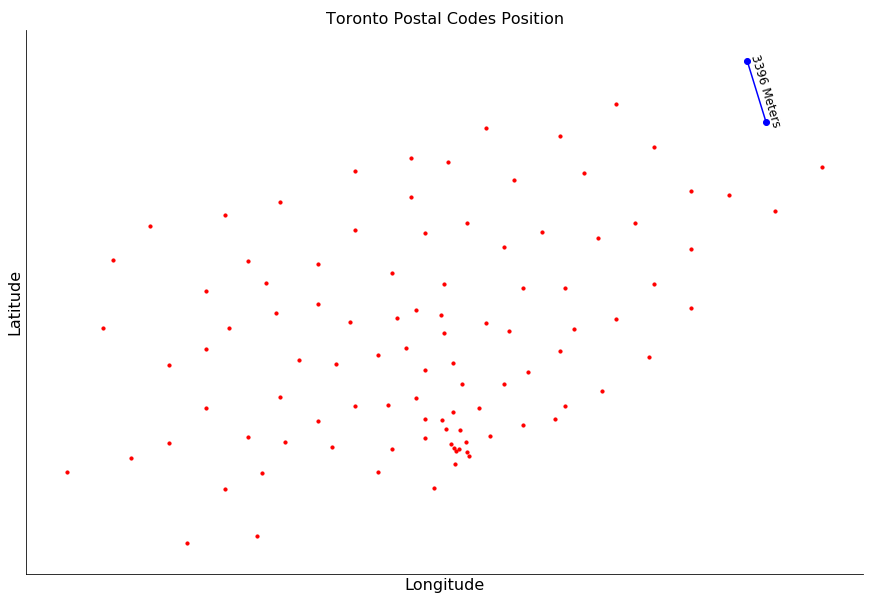

In [80]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

Radius cover for each postal code is added

In [81]:
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0


Iterate each row of the dataframe

In [82]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): 
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

In [83]:
CLIENT_ID = 'OVRXU0L3BTQWDGLVIFS1LQZONX0YUIDMBR1QUKZIYVILNAII'
CLIENT_SECRET = '0TD3IABDCRIQ0AANXYQJB0AYFWSKPHP15HR41O2LMLOUXLY4' 
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OVRXU0L3BTQWDGLVIFS1LQZONX0YUIDMBR1QUKZIYVILNAII
CLIENT_SECRET:0TD3IABDCRIQ0AANXYQJB0AYFWSKPHP15HR41O2LMLOUXLY4


To explore the data returned by the Foursquare API, a maximum of 100 venues from the first postcode are requested in a radius of 500 meters
#function to format url

In [84]:
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [85]:
first_postcode = postcodes_with_coordinates_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=OVRXU0L3BTQWDGLVIFS1LQZONX0YUIDMBR1QUKZIYVILNAII&client_secret=0TD3IABDCRIQ0AANXYQJB0AYFWSKPHP15HR41O2LMLOUXLY4&ll=43.7635726,-79.1887115&v=20180605&radius=1205.0&limit=100'

Function to get batch of venues as a dataframe

In [86]:
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

venues_df = get_venues(url)
venues_df.head()

C:\Users\fidel\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups
0,e-0-4bc366dab492d13a51b2a860-0,0,"[{'summary': 'This spot is popular', 'type': '...",4bc366dab492d13a51b2a860,Chick-N-Joy,4449 Kingston Road,at Lawrence and Morningside,43.768752,-79.187982,"[{'label': 'display', 'lat': 43.76875171771289...",579,M1E 2N7,CA,Scarborough,ON,Canada,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",0,[]
1,e-0-4b3a9504f964a520646a25e3-1,0,"[{'summary': 'This spot is popular', 'type': '...",4b3a9504f964a520646a25e3,LCBO,4525 Kingston Rd.,at Lawrence Ave. E,43.771462,-79.184384,"[{'label': 'display', 'lat': 43.77146181777272...",944,M1E 2P1,CA,Toronto,ON,Canada,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",0,[]
2,e-0-4ba164fdf964a52039b337e3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4ba164fdf964a52039b337e3,Bulk Barn,4525 Kingston Rd,Morningside Crossing,43.771342,-79.184341,"[{'label': 'display', 'lat': 43.77134173380578...",933,NaN,CA,West Hill,ON,Canada,"[4525 Kingston Rd (Morningside Crossing), West...","[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",0,[]
3,e-0-4c9fdb04542b224bca4201a0-3,0,"[{'summary': 'This spot is popular', 'type': '...",4c9fdb04542b224bca4201a0,Little Caesars Pizza,4218 Lawrence Avenue East,NaN,43.769046,-79.184386,"[{'label': 'display', 'lat': 43.76904597684398...",701,M1E 4X9,CA,Scarborough,ON,Canada,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",0,[]
4,e-0-4beca2f9d6e676b0538764d4-4,0,"[{'summary': 'This spot is popular', 'type': '...",4beca2f9d6e676b0538764d4,Booster Juice,"4525 Kingston Road, Unit #H8",at Collinsgrove Rd.,43.770668,-79.184150,"[{'label': 'display', 'lat': 43.77066813, 'lng...",870,M1E 2P1,CA,Scarborough,ON,Canada,"[4525 Kingston Road, Unit #H8 (at Collinsgrove...","[{'id': '52f2ab2ebcbc57f1066b8b41', 'name': 'S...",0,[]


Function to clean the venues dataframe

In [87]:

def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'id': '52f2ab2ebcbc57f1066b8b41', 'name': 'S...",43.770668,-79.184150,Booster Juice


In [88]:
venues_df.loc[0, 'Category']

[{'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'shortName': 'Fried Chicken',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'primary': True}]

Function that extract the category name

In [89]:

def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Liquor Store,43.771462,-79.184384,LCBO
2,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
3,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
4,Smoothie Shop,43.770668,-79.184150,Booster Juice
5,Restaurant,43.768122,-79.190493,Swiss Chalet
6,Bank,43.766790,-79.191151,RBC Royal Bank
7,Breakfast Spot,43.772319,-79.184900,Sunset Grill
8,Coffee Shop,43.770281,-79.185016,Starbucks
9,Beer Store,43.769793,-79.187505,The Beer Store


Function to construct the dataframe with all the venues (max 100 venues per postal code)

In [90]:

def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postal Code', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [91]:
all_venues = get_all_venues(postcodes_with_coordinates_df['Postal Code'], postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head()

The total number of venues returned is  3307


,Postal Code,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
2,M1B,43.806686,-79.194353,Penguin Exhibit,43.819435,-79.185959,Zoo Exhibit
3,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
4,M1B,43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant


In [92]:
print('Total Toronto postcodes:', postcodes_with_coordinates_df['Postal Code'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postal Code'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


In [93]:
postcodes_diff = np.setdiff1d(postcodes_with_coordinates_df['Postal Code'].values,all_venues['Postal Code'].unique())
postcodes_with_coordinates_df[postcodes_with_coordinates_df['Postal Code']==postcodes_diff[0]]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


In [94]:
venues_in_postcode = all_venues.groupby('Postal Code').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postal Code', '# of Venues']).set_index('Postal Code').join(postcodes_with_coordinates_df[['Postal Code','Distance']].set_index('Postal Code'), on='Postal Code').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head()

,Postal Code,# of Venues,Distance
0,M1B,38,1698
1,M1C,11,1625
2,M1E,28,1205
3,M1G,4,913
4,M1H,23,913


In [95]:
venues_in_postcode[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,32.106796
std,24.974070
min,0.000000
25%,13.000000
50%,26.000000
75%,43.000000
max,100.000000


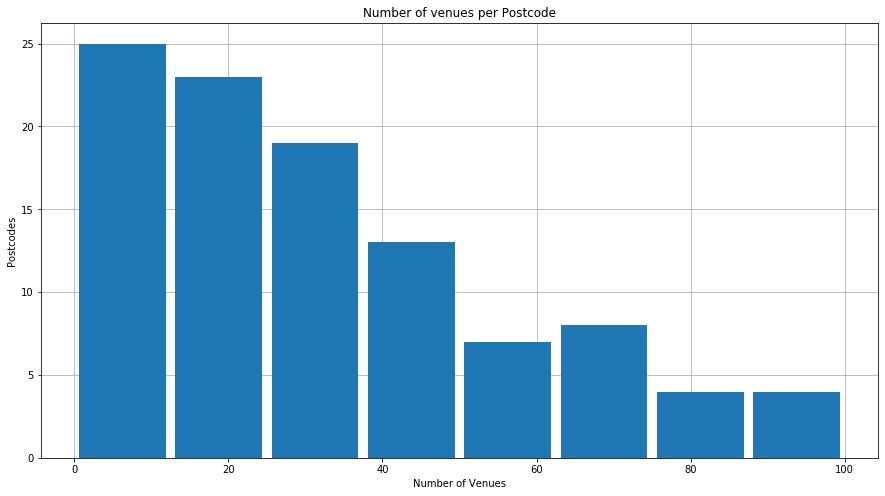

In [96]:
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

In [97]:
density_venues_in_postcode = all_venues.groupby('Postal Code').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postal Code', 'Density']).set_index('Postal Code').join(postcodes_with_coordinates_df[['Postal Code','Distance']].set_index('Postal Code'), on='Postal Code').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head()

,Postal Code,Density,Distance
0,M1B,22,1698.0
1,M1C,6,1625.0
2,M1E,23,1205.0
3,M1G,4,913.0
4,M1H,25,913.0


In [98]:
density_venues_in_postcode[['Density']].describe()

,Density
count,103.000000
mean,45.106796
std,46.143832
min,0.000000
25%,15.000000
50%,31.000000
75%,56.000000
max,274.000000


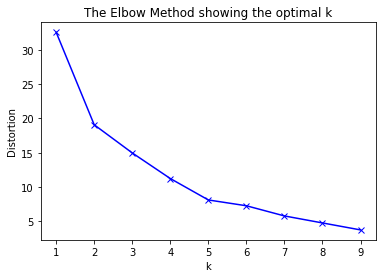

In [99]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [100]:
num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 0 0 0 0 0 0 4 0 0 4 4 4 4 4 4 0 0 4 0 0 4 2 4 4 4 4 4 4 4 0 0 0 0 0 0 0
 2 2 4 4 1 4 1 0 0 4 2 0 2 0 2 3 2 3 4 2 1 3 2 1 4 0 0 4 2 1 4 2 1 4 4 0 0
 4 4 1 2 0 0 4 2 2 2 0 4 4 0 4 4 0 4 0 0 0 0 0 0 0 0 0 0 0]


In [101]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head()

,Postal Code,Density,Distance,Cluster
0,M1B,22,1698.0,0
1,M1C,6,1625.0,0
2,M1E,23,1205.0,0
3,M1G,4,913.0,0
4,M1H,25,913.0,0


In [102]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['Postal Code']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Postal Codes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postal Codes
0,0,13,44
1,4,39,34
2,2,81,15
3,1,126,7
4,3,221,3


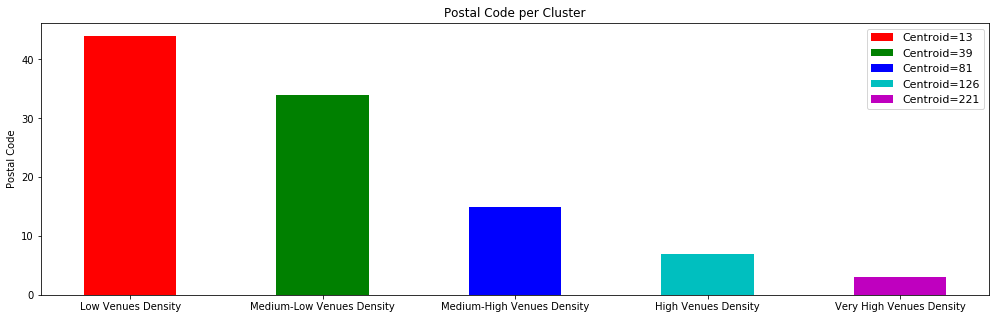

In [103]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
colors = ['r','g','b','c','m']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Postal Codes'][id], 0.48, color=colors[id])

ax.set_ylabel('Postal Code')
ax.set_title('Postal Code per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()

In [104]:
postcodes_with_coordinates_df = pd.concat([postcodes_with_coordinates_df[:56],postcodes_with_coordinates_df[57:],postcodes_with_coordinates_df[56:57]]) #move M5E to the last row
postcodes_with_coordinates_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan','magenta']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map